In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/TOM - projekt/DANE/archive_better.zip" -d "/content/drive/My Drive/TOM - projekt/DANE/better"

Import bibliotek

In [ ]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.utils
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D

from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.efficientnet import EfficientNetB1



Przedstawienie danych w zbiorze

In [ ]:
#Dostęp do zdjęć
train_path = "/content/drive/My Drive/TOM - projekt/DANE/better/train"
test_path = "/content/drive/My Drive/TOM - projekt/DANE/better/test"
val_path = "/content/drive/My Drive/TOM - projekt/DANE/better/val"

#Liczba zdjęć w folderze train
print("Train set:")
print(f"Pneumonia = {len(os.listdir(os.path.join(train_path, 'opacity')))}")
print(f"Normal = {len(os.listdir(os.path.join(train_path, 'normal')))}")

#Liczba zdjęć w folderze test
print("\nTest set:")
print(f"Pneumonia = {len(os.listdir(os.path.join(test_path, 'opacity')))}")
print(f"NormalL = {len(os.listdir(os.path.join(test_path, 'normal')))}")

#Liczba zdjęć w folderze val
print("\nValidation set:")
print(f"Pneumonia = {len(os.listdir(os.path.join(val_path, 'opacity')))}")
print(f"Normal = {len(os.listdir(os.path.join(val_path, 'normal')))}")


Train set:
Pneumonia = 3110
Normal = 1082

Test set:
Pneumonia = 390
NormalL = 234

Validation set:
Pneumonia = 773
Normal = 267


Wizualizacja przykładowych 9 zdjęć zapalenia ze zbioru Train

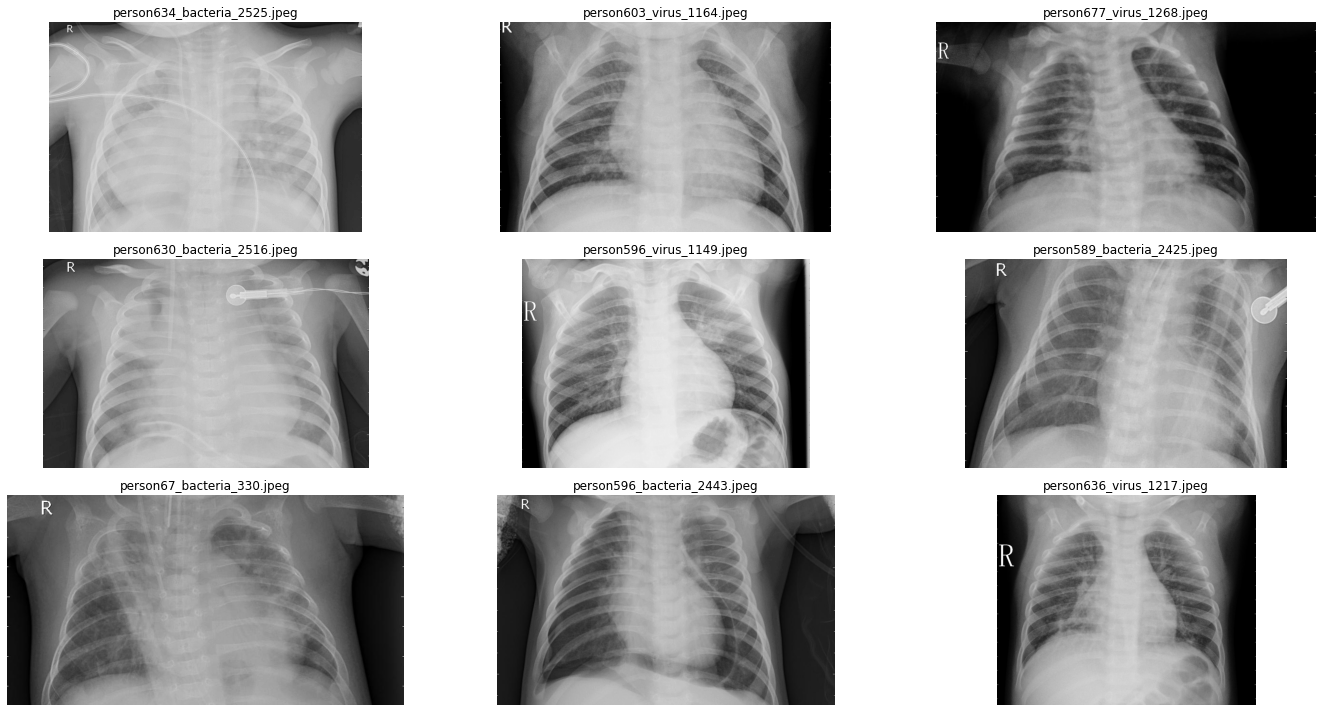

In [ ]:
pneumonia_path = "/content/drive/My Drive/TOM - projekt/DANE/better/train/opacity"
pneumonia_img = os.listdir("/content/drive/My Drive/TOM - projekt/DANE/better/train/opacity")

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_path, pneumonia_img[i]))
    plt.title(pneumonia_img[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

Wizualizacja 9 przykładowych zdjęć zdrowych ze zbioru Train

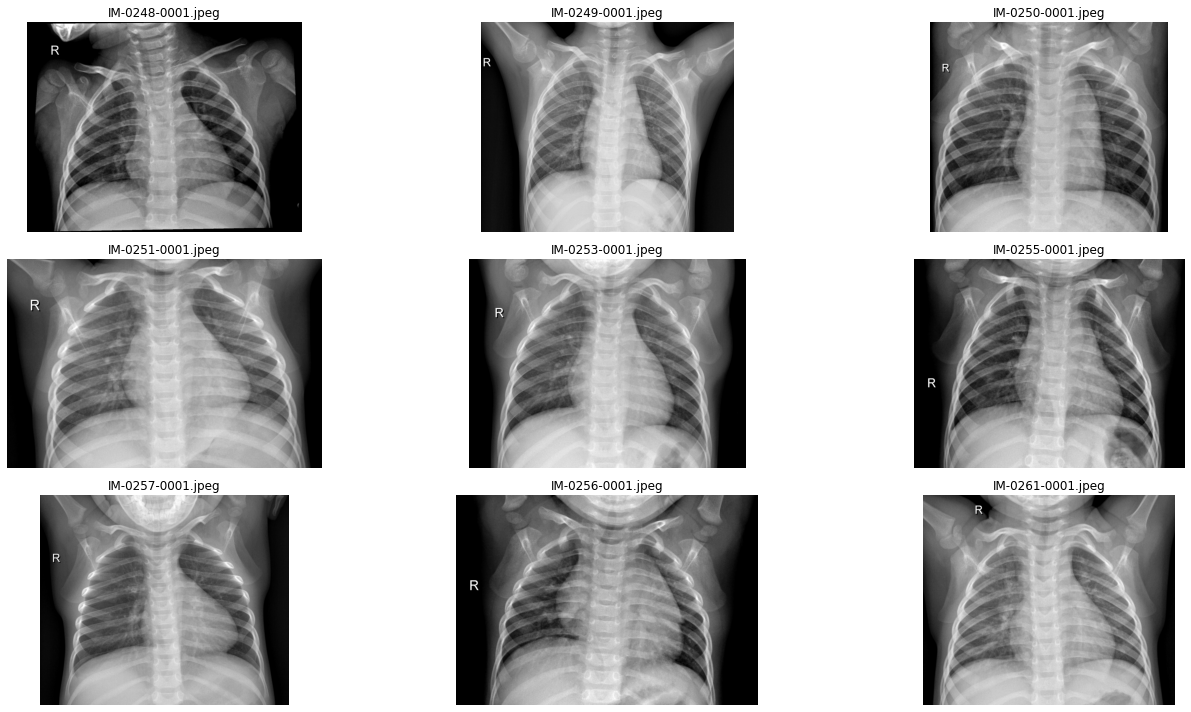

In [ ]:
normal_path = "/content/drive/My Drive/TOM - projekt/DANE/better/train/normal"
normal_img = os.listdir("/content/drive/My Drive/TOM - projekt/DANE/better/train/normal")

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_path, normal_img[i]))
    plt.title(normal_img[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

Wizualizacja przykładowego zdjęcia

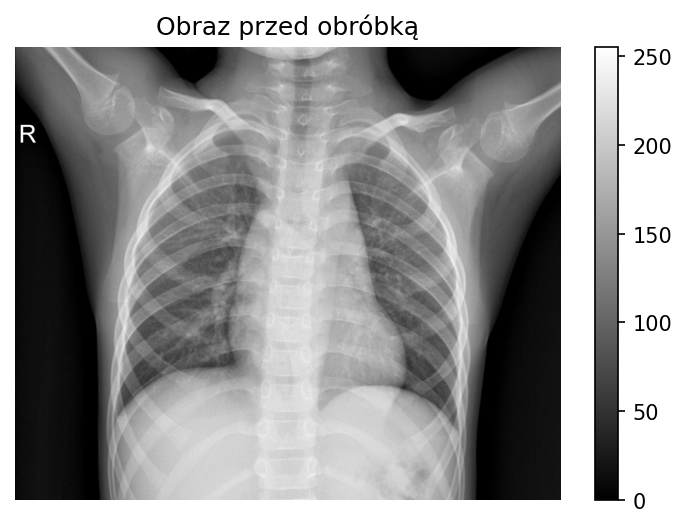

Rozmiar zdjęcia: (1990, 2396)
Max pixel: 255.00
Min pixel 0.00
Średnia: 118.58 
Odchylenie standardowe: 71.68


In [ ]:
example_path = "/content/drive/My Drive/TOM - projekt/DANE/better/train/normal"
example_img = os.listdir("/content/drive/My Drive/TOM - projekt/DANE/better/train/normal")

sample_img = plt.imread(os.path.join(example_path, example_img[1]))

plt.figure(dpi=150)
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Obraz przed obróbką')
plt.axis("off")
plt.show()

print(f"Rozmiar zdjęcia: {sample_img.shape}")
print(f"Max pixel: {sample_img.max():.2f}")
print(f"Min pixel {sample_img.min():.2f}")
print(f"Średnia: {sample_img.mean():.2f} ")
print(f"Odchylenie standardowe: {sample_img.std():.2f}")

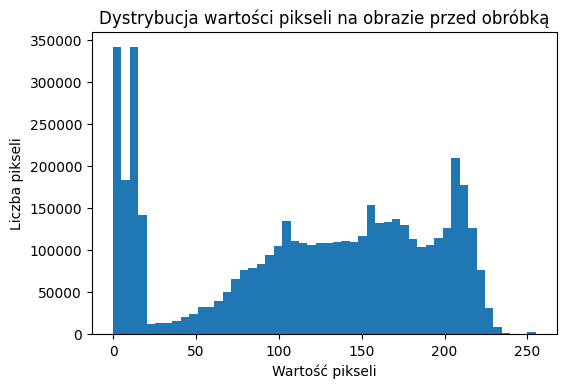

In [ ]:
plt.figure(dpi=100)
plt.hist(sample_img.ravel(), bins = 50)

plt.title('Dystrybucja wartości pikseli na obrazie przed obróbką')
plt.xlabel('Wartość pikseli')
plt.ylabel('Liczba pikseli')
plt.show()

Transfromacja zdjęć

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True)

Podział na zbiór treningowy, testowy, walidacyjny

In [ ]:
train = img_gen.flow_from_directory(
    train_path, 
    batch_size=8, 
    shuffle=True, 
    class_mode='binary', 
    target_size=(180, 180))

validation = img_gen.flow_from_directory(
    val_path, 
    batch_size=1, 
    shuffle=False, 
    class_mode='binary', 
    target_size=(180, 180))

test = img_gen.flow_from_directory(
    test_path, 
    batch_size=1, 
    shuffle=False, 
    class_mode='binary', 
    target_size=(180, 180))

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Wizualizacaj zdjęcia po transformacji

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


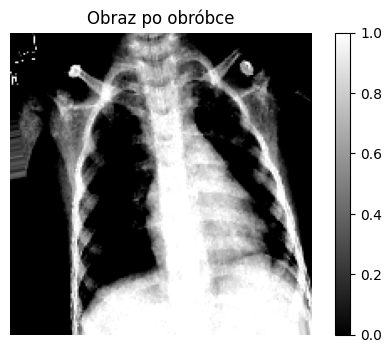

Rozmiar zdjęcia: (8, 180, 180, 3)
Max pixel: 3.04
Min pixel -2.71
Średnia: -0.00 
Odchylenie standardowe: 1.00


In [ ]:
trans_img, label = train.__getitem__(0)

plt.figure(dpi=100)
plt.imshow(trans_img[1], cmap='gray')
plt.colorbar()
plt.axis("off")
plt.title('Obraz po obróbce')
plt.show()

print(f"Rozmiar zdjęcia: {trans_img.shape}")
print(f"Max pixel: {trans_img.max():.2f}")
print(f"Min pixel {trans_img.min():.2f}")
print(f"Średnia: {trans_img.mean():.2f} ")
print(f"Odchylenie standardowe: {trans_img.std():.2f}")

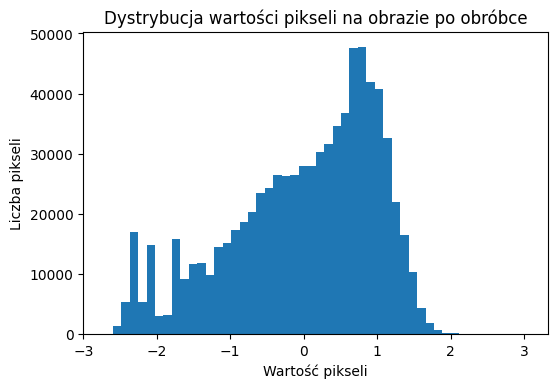

In [ ]:
plt.figure(dpi=100)
plt.hist(trans_img.ravel(), bins = 50)

plt.title('Dystrybucja wartości pikseli na obrazie po obróbce')
plt.xlabel('Wartość pikseli')
plt.ylabel('Liczba pikseli')
plt.show()

Wyznaczenie wag klas

In [ ]:
class_weights = sklearn.utils.class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(train.classes), 
            y = train.classes)

class_weights = dict(zip(np.unique(train.classes), class_weights))

print(class_weights)

{0: 1.9371534195933457, 1: 0.6739549839228296}


Zdefiniowanie obliczanych metryk

In [ ]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='AUC')
           ]

**NASZ MODEL** - implementacja

In [ ]:
our_model = Sequential()

our_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(MaxPool2D(pool_size=(2, 2)))

our_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(MaxPool2D(pool_size=(2, 2)))

our_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(MaxPool2D(pool_size=(2, 2)))

our_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
our_model.add(BatchNormalization())
our_model.add(MaxPool2D(pool_size=(2, 2)))

our_model.add(Flatten())
our_model.add(Dense(128, activation='relu'))
our_model.add(Dropout(0.3))

our_model.add(Dense(1, activation='sigmoid'))

our_model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=METRICS)

In [ ]:
our_model.summary()

Trenowanie modelu

In [ ]:
our_r = our_model.fit(
    train, 
    epochs = 10,
    validation_data = validation, 
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_steps = 25
    )

Epoch 1/10
 78/100 [======================>.......] - ETA: 45s - loss: 0.8312 - accuracy: 0.7885 - precision: 0.9316 - recall: 0.7696 - AUC: 0.8586

Ewaluacja modelu

In [ ]:
our_evaluation = our_model.evaluate(test)

print(f"Test Accuracy: {our_evaluation[1]:.2f}")
print(f"Test Precision: {our_evaluation[2]:.2f}")
print(f"Test Recall: {our_evaluation[3]:.2f}")
print(f"Test AUC: {our_evaluation[4]:.2f}")

624/624 [==============================] - 102s 164ms/step - loss: 0.6360 - accuracy: 0.7404 - precision: 0.8775 - recall: 0.6795 - AUC: 0.8485
Test Accuracy: 0.74
Test Precision: 0.88
Test Recall: 0.68
Test AUC: 0.85


In [ ]:
our_pred = our_model.predict(test)

Macierz pomyłek

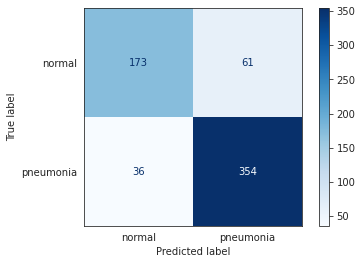

In [ ]:
matrix = confusion_matrix(test.classes, (our_pred > 0.5).ravel())

ConfusionMatrixDisplay(matrix, display_labels = ["normal", "pneumonia"]).plot(cmap=plt.cm.Blues)
plt.show()

Krzywa ROC

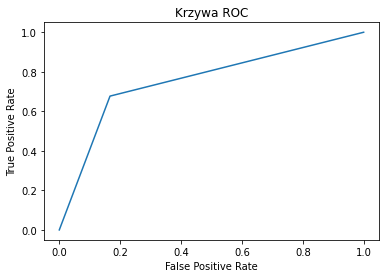

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes, (our_pred > 0.5).ravel())

plt.plot(fpr,tpr)
plt.title("Krzywa ROC")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**DENSENET121** - implementacja

In [ ]:
layers = dense121_base_model.layers
print(f"The model has {len(layers)} layers")

The model has 427 layers


In [ ]:
print(f"The input shape {dense121_base_model.input}")
print(f"The output shape {dense121_base_model.output}")

The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 1024), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'")


In [ ]:
dense121_base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

from keras.models import Model

x = dense121_base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation="sigmoid")(x)
model = Model(inputs=dense121_base_model.input, outputs=predictions)

dense_model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=METRICS)

Trenowanie modelu

In [ ]:
dense_r = dense_model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weights,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - 44s 297ms/step - loss: 0.7231 - accuracy: 0.5738 - precision: 0.8205 - recall: 0.5415 - AUC: 0.6579 - val_loss: 0.1232 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 32s 317ms/step - loss: 0.4980 - accuracy: 0.7200 - precision: 0.9454 - recall: 0.6644 - AUC: 0.8623 - val_loss: 0.6925 - val_accuracy: 0.7600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 25s 249ms/step - loss: 0.3973 - accuracy: 0.8075 - precision: 0.9476 - recall: 0.7860 - AUC: 0.9075 - val_loss: 0.5078 - val_accuracy: 0.8400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 25s 252ms/step - loss: 0.3760 - accuracy: 0.8375 - precision: 0.9538 - recall: 0.8236 - AUC: 0.9158 - val_loss: 0.1540 - val_accuracy

Ewaluacja modelu

In [ ]:
dense_evaluation= dense_model.evaluate(test)
 
print(f"Test Accuracy: {dense_evaluation[1]:.2f}")
print(f"Test Precision: {dense_evaluation[2]:.2f}")
print(f"Test Recall: {dense_evaluation[3]:.2f}")
print(f"Test AUC: {dense_evaluation[4]:.2f}")

624/624 [==============================] - 20s 32ms/step - loss: 0.3975 - accuracy: 0.8429 - precision: 0.8274 - recall: 0.9462 - AUC: 0.9169
Test Accuracy: 0.84
Test Precision: 0.83
Test Recall: 0.95
Test AUC: 0.92


In [ ]:
dense_pred = dense_model.predict(test)

Macierz pomyłek

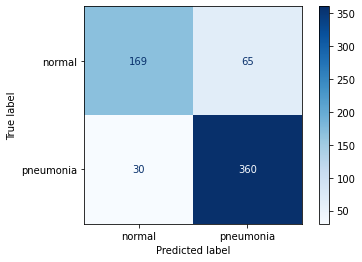

In [ ]:
matrix = confusion_matrix(test.classes, (dense_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["normal", "pneumonia"]).plot(cmap = plt.cm.Blues)
plt.show()

Krzywa ROC

AUC:0.80%


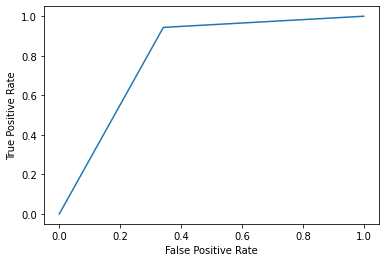

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes, (dense_pred > 0.5).ravel())

AUC = metrics.auc(fpr, tpr)
print(f"AUC:{AUC :.2f}%")

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**VGG16** - implementacja

In [ ]:
vgg16_base_model = VGG16(input_shape=(180,180,3), include_top=False, weights='imagenet')

vgg_model = tf.keras.Sequential([
        vgg16_base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.6),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1,activation="sigmoid")
    ])

adam_001 = tf.keras.optimizers.Adam(learning_rate=0.001)

vgg_model.compile(loss='binary_crossentropy', 
                  optimizer = adam_001,  
                  metrics = METRICS)

Trenowanie modelu

In [ ]:
vgg_r = vgg_model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_steps = 25)

Epoch 1/10
100/100 [==============================] - 23s 204ms/step - loss: 0.6810 - accuracy: 0.6000 - precision: 0.8533 - recall: 0.3493 - AUC: 0.6990 - val_loss: 2.3042e-07 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 21s 208ms/step - loss: 0.5607 - accuracy: 0.6975 - precision: 0.9183 - recall: 0.6397 - AUC: 0.8013 - val_loss: 0.3119 - val_accuracy: 0.9600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 20s 204ms/step - loss: 0.5039 - accuracy: 0.7450 - precision: 0.9207 - recall: 0.7133 - AUC: 0.8383 - val_loss: 1.3466 - val_accuracy: 0.4800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 20s 201ms/step - loss: 0.4868 - accuracy: 0.7700 - precision: 0.9446 - recall: 0.7282 - AUC: 0.8620 - val_loss: 6.9290 - val_accu

Ewaluacja

In [ ]:
vgg_evaluation= vgg_model.evaluate(test)
 
print(f"Test Accuracy: {vgg_evaluation[1]:.2f}")
print(f"Test Precision: {vgg_evaluation[2]:.2f}")
print(f"Test Recall: {vgg_evaluation[3]:.2f}")
print(f"Test AUC: {vgg_evaluation[4]:.2f}")

624/624 [==============================] - 16s 25ms/step - loss: 1.2481 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000 - AUC: 0.8494
Test Accuracy: 0.62
Test Precision: 0.62
Test Recall: 1.00
Test AUC: 0.85


In [ ]:
vgg_pred = vgg_model.predict(test)

Macierz pomyłek

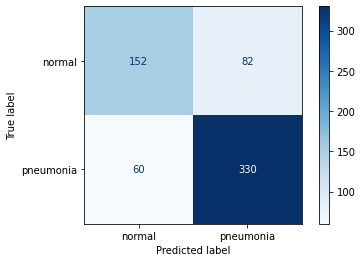

In [ ]:
matrix = confusion_matrix(test.classes, (vgg_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["normal", "pneumonia"]).plot(cmap = plt.cm.Blues)
plt.show()

Krzywa ROC

AUC:0.71%


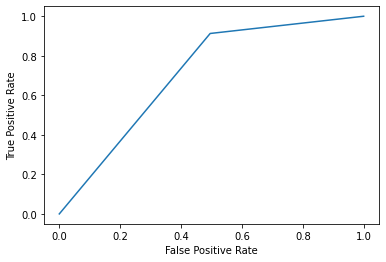

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes, (vgg_pred > 0.5).ravel())

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**RESNET50** - implementacja

In [ ]:
resnet50_base_model = ResNet50(input_shape=(180,180,3), include_top=False, weights='imagenet')

resnet_model = tf.keras.Sequential([
        resnet50_base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1,activation="sigmoid")])

adam_001 = tf.keras.optimizers.Adam(learning_rate=0.001)

resnet_model.compile(loss='binary_crossentropy', 
                  optimizer = adam_001,  
                  metrics = METRICS)

Trenowanie modelu

In [ ]:
resnet_r = resnet_model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_steps = 25)

Epoch 1/10
100/100 [==============================] - 32s 248ms/step - loss: 0.6791 - accuracy: 0.6413 - precision: 0.8479 - recall: 0.5954 - AUC: 0.7360 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 22s 222ms/step - loss: 0.6800 - accuracy: 0.6488 - precision: 0.8827 - recall: 0.5955 - AUC: 0.7388 - val_loss: 5.7742 - val_accuracy: 0.1600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 23s 230ms/step - loss: 0.4984 - accuracy: 0.7525 - precision: 0.9386 - recall: 0.7239 - AUC: 0.8483 - val_loss: 36.2297 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 23s 224ms/step - loss: 0.5378 - accuracy: 0.7575 - precision: 0.8974 - recall: 0.7572 - AUC: 0.8219 - val_loss: 4774.0010 - 

Ewaluacja

In [ ]:
resnet_evaluation= resnet_model.evaluate(test)
 
print(f"Test Accuracy: {resnet_evaluation[1]:.2f}")
print(f"Test Precision: {resnet_evaluation[2]:.2f}")
print(f"Test Recall: {resnet_evaluation[3]:.2f}")
print(f"Test AUC: {resnet_evaluation[4]:.2f}")

624/624 [==============================] - 17s 28ms/step - loss: 0.5099 - accuracy: 0.8221 - precision: 0.8361 - recall: 0.8897 - AUC: 0.8441
Test Accuracy: 0.82
Test Precision: 0.84
Test Recall: 0.89
Test AUC: 0.84


Macierz pomyłek

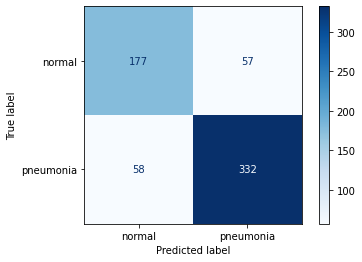

In [ ]:
resnet_pred = resnet_model.predict(test)

matrix = confusion_matrix(test.classes, (resnet_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["normal", "pneumonia"]).plot(cmap = plt.cm.Blues)
plt.show()

Krzywa ROC

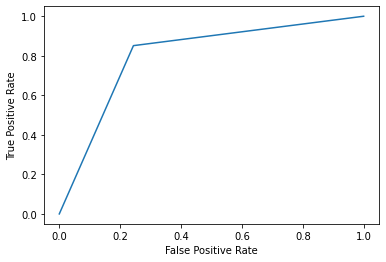

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes, (resnet_pred > 0.7).ravel())

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**INCEPTIONV3** - implementacja



In [ ]:
inceptionv3_base_model = InceptionV3(input_shape=(180,180,3), include_top=False, weights='imagenet')

inception_model = tf.keras.Sequential([
        inceptionv3_base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1,activation="sigmoid")])

inception_model.compile(loss='binary_crossentropy', 
                  optimizer = adam_001,  
                  metrics = METRICS)

Trenowanie modelu

In [ ]:
inceprion_r = inception_model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_steps = 25)

Epoch 1/10
100/100 [==============================] - 31s 213ms/step - loss: 0.7858 - accuracy: 0.5225 - precision: 0.6835 - recall: 0.6821 - AUC: 0.5365 - val_loss: 1284505.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 20s 195ms/step - loss: 0.7436 - accuracy: 0.5500 - precision: 0.7805 - recall: 0.5424 - AUC: 0.5806 - val_loss: 127.1063 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 20s 195ms/step - loss: 0.6305 - accuracy: 0.6075 - precision: 0.8642 - recall: 0.5582 - AUC: 0.7114 - val_loss: 1351.5804 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 20s 197ms/step - loss: 0.5847 - accuracy: 0.6712 - precision: 0.8932 - recall: 0.6269 - AUC: 0.7669 - val_loss

Ewaluacja

In [ ]:
inception_evaluation = inception_model.evaluate(test)
 
print(f"Test Accuracy: {inception_evaluation[1]:.2f}")
print(f"Test Precision: {inception_evaluation[2]:.2f}")
print(f"Test Recall: {inception_evaluation[3]:.2f}")
print(f"Test AUC: {inception_evaluation[4]:.2f}")

624/624 [==============================] - 18s 29ms/step - loss: 17.1928 - accuracy: 0.6763 - precision: 0.6667 - recall: 0.9641 - AUC: 0.6126
Test Accuracy: 0.68
Test Precision: 0.67
Test Recall: 0.96
Test AUC: 0.61


Macierz pomyłek

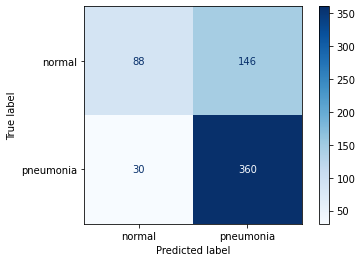

In [ ]:
inception_pred = inception_model.predict(test)

matrix = confusion_matrix(test.classes, (inception_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["normal", "pneumonia"]).plot(cmap = plt.cm.Blues)
plt.show()

Krzywa ROC

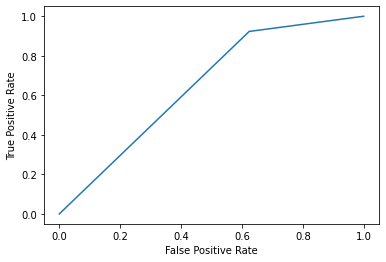

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes, (inception_pred > 0.7).ravel())

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**EFFICIENTNETB1** - implementacja

In [ ]:
efficient_base_model = EfficientNetB1(input_shape=(180,180,3), include_top=False, weights='imagenet')

efficient_model = tf.keras.Sequential([
        efficient_base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32,activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1,activation="sigmoid")])

efficient_model.compile(loss='binary_crossentropy', 
                  optimizer = adam_001,  
                  metrics = METRICS)

Trenowanie modelu

In [ ]:
efficient_r = efficient_model.fit(
    train,
    epochs = 10,
    validation_data = validation,
    class_weight = class_weights,
    steps_per_epoch = 100,
    validation_steps = 25)

Epoch 1/10
100/100 [==============================] - 37s 239ms/step - loss: 0.6970 - accuracy: 0.6662 - precision: 0.7144 - recall: 0.8064 - AUC: 0.5392 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 21s 212ms/step - loss: 0.5039 - accuracy: 0.7775 - precision: 0.9256 - recall: 0.7716 - AUC: 0.8386 - val_loss: 2.2400 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 21s 214ms/step - loss: 0.4159 - accuracy: 0.7887 - precision: 0.9509 - recall: 0.7623 - AUC: 0.8888 - val_loss: 2.6766 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 22s 215ms/step - loss: 0.3943 - accuracy: 0.8000 - precision: 0.9514 - recall: 0.7756 - AUC: 0.8983 - val_loss: 4.1371e-1

Ewaluacja

In [ ]:
efficient_evaluation = efficient_model.evaluate(test)
 
print(f"Test Accuracy: {efficient_evaluation[1]:.2f}")
print(f"Test Precision: {efficient_evaluation[2]:.2f}")
print(f"Test Recall: {efficient_evaluation[3]:.2f}")
print(f"Test AUC: {efficient_evaluation[4]:.2f}")

624/624 [==============================] - 19s 30ms/step - loss: 0.4638 - accuracy: 0.7804 - precision: 0.7674 - recall: 0.9308 - AUC: 0.8561
Test Accuracy: 0.78
Test Precision: 0.77
Test Recall: 0.93
Test AUC: 0.86


In [ ]:
efficient_pred = efficient_model.predict(test)

Macierz pomyłek

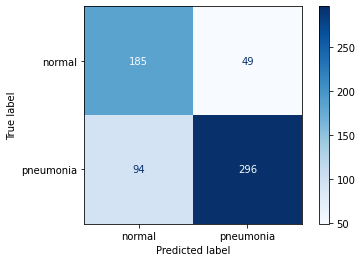

In [ ]:
matrix = confusion_matrix(test.classes, (efficient_pred > 0.7).ravel())
 
ConfusionMatrixDisplay(matrix, display_labels = ["normal", "pneumonia"]).plot(cmap = plt.cm.Blues)
plt.show()

Krzywa ROC

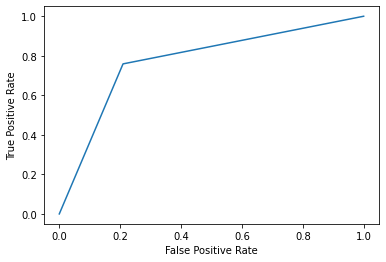

In [ ]:
fpr, tpr, _ = metrics.roc_curve(test.classes, (efficient_pred > 0.7).ravel())

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()